In [1]:
# establish a baseline performance
import os
import json
import numpy as np
from skimage.io import imread 
from skimage.transform import resize
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import classification_report



In [2]:
PROJECT_ROOT = os.getcwd()

In [3]:
root = os.path.join(PROJECT_ROOT, 'brain tumor data')

In [4]:
os.listdir(root) 

['test', 'valid', 'README.txt', 'train']

In [5]:
test_path = root+'/test/'
train_path = root+'/train/'
validation_path = root + '/valid/'
fixed_annotation_file = root + '/train/fixed_annotations.json'

In [6]:
# load annotation and get image path and labels
def load_data(fixed_annotation_file, train_path):
    with open(fixed_annotation_file, 'r') as f:
        coco_data = json.load(f)
        
    image_id_to_label = {ann['image_id']: ann['category_id'] for ann in coco_data['annotations']}
    image_list = []
    label_list = []

    for img in coco_data['images']:
        file_name = img['file_name']
        img_id = img['id']
        label = image_id_to_label.get(img_id) # use get(img_id) is to look up the category_id(label) for the image using its ID

        if label is not None:
            image_path = os.path.join(train_path, file_name)
            image_list.append(image_path)
            label_list.append(label - 1) # convert category_id 1 and 2 to label 0 and 1
    
    return image_list , label_list
    


In [7]:
# extract HOG features
def extract_hog_features(train_path, img_size=(128,128)):
    features = []
    feature_length_printed = False
    for path in train_path:
        try:
            image = imread(path, as_gray=True)
            image = resize(image, img_size)
            hog_feature = hog(image, pixels_per_cell=(16,16), cells_per_block=(2,2), feature_vector=True)
            if not feature_length_printed:
                feature_length_printed = True
            features.append(hog_feature)   
               
        except Exception as e:
            print(f"Fail to process {path}: {e}")
    
    return np.array(features)



In [8]:
# define the path
train_ann = train_path + 'fixed_annotations.json'
train_img_dir = root + '/train'

In [9]:
# load validation data
val_ann = validation_path + '_annotations.coco.json'
val_img_dir = root + '/valid'

In [10]:
import os
import random
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from sklearn.svm import SVC
from joblib import dump
import time
from tqdm import tqdm

save_dir_svm = os.path.join(PROJECT_ROOT, 'base_SVM_HOG_new')
os.makedirs(save_dir_svm,exist_ok = True)

num_runs = 3
accuracies = []
best_acc = 0.0
best_model = None
start_time = time.time()

for run in range(num_runs):
    print(f"\n===== Run {run + 1} =====")
    random.seed(42 + run)
    # load training data
    X_train_paths, y_train = load_data(train_ann, train_img_dir)
    combined_train = list(zip(X_train_paths, y_train))
    random.shuffle(combined_train)
    X_train_paths, y_train = zip(*combined_train)

    X_val_paths, y_val = load_data(val_ann, val_img_dir)
    combined_val = list(zip(X_val_paths, y_val))
    random.shuffle(combined_val)
    X_val_paths, y_val = zip(*combined_val)

    # extract HOG features
    X_train = extract_hog_features(X_train_paths)
    X_val = extract_hog_features(X_val_paths)

    # train SVM classifier
    clf = SVC(kernel='linear', probability=True)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(classification_report(y_val, y_pred))
    accuracies.append(acc)

    print(f"Accuracy for run {run + 1}: {acc:.4f}")

    # track the best model
    if acc > best_acc:
        best_acc = acc
        best_model = clf
        print('save best SVM + HOG model')

# save the best model
model_save_path = os.path.join(save_dir_svm, 'best_svm_hog_model.pkl')
dump(best_model, model_save_path)
# Print relative path only
print("\nBest model saved to:", os.path.relpath(model_save_path))


print(f'\nDuration: {time.time() - start_time:.0f} seconds') # Print time elapsed

# final result
print("\n=== Final Averaged Result ===")
print(f"Validation Accuracy: {np.mean(accuracies):.4f} +- {np.std(accuracies):.4f}")




===== Run 1 =====
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       210
           1       0.93      0.94      0.93       219

    accuracy                           0.93       429
   macro avg       0.93      0.93      0.93       429
weighted avg       0.93      0.93      0.93       429

Accuracy for run 1: 0.9324
save best SVM + HOG model

===== Run 2 =====
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       210
           1       0.93      0.94      0.93       219

    accuracy                           0.93       429
   macro avg       0.93      0.93      0.93       429
weighted avg       0.93      0.93      0.93       429

Accuracy for run 2: 0.9324

===== Run 3 =====
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       210
           1       0.93      0.94      0.93       219

    accuracy                           0.93  

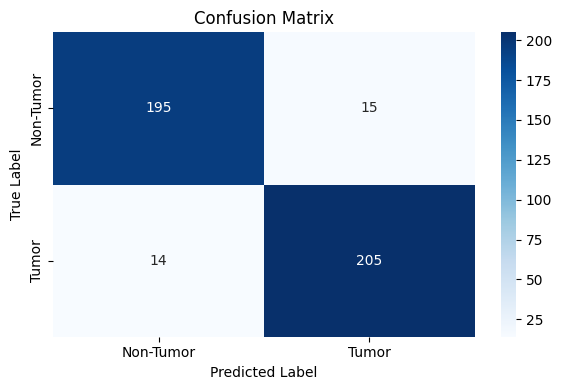

In [11]:
# confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Tumor', 'Tumor'],
            yticklabels=['Non-Tumor','Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [12]:
# extract HOG features for the specific image 
#X_train_spe = extract_hog_features(X_train_paths)
#X_val_spe = extract_hog_features(X_val_paths)

Text(0.5, 1.0, 'Original Image')

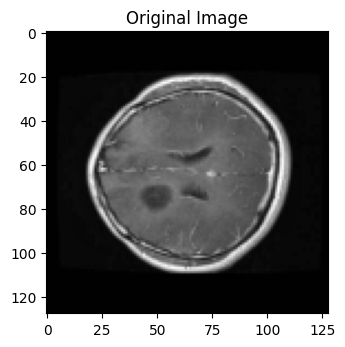

In [13]:
# visualize the feature for 1st image
import matplotlib.pyplot as plt
image = imread(X_train_paths[0], as_gray=True)
image = resize(image, (128,128))
feature, hog_feature = hog(image, pixels_per_cell=(16,16), cells_per_block=(2,2), visualize=True, feature_vector=True)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")

In [14]:
# check this image's file name and category
# 1: extract the image file name from the full path
target_file = os.path.basename(X_train_paths[0])

# 2: find the image id and category for the target file
with open(train_ann, 'r') as f:
    coco_data = json.load(f)
for img in coco_data['images']:
    if img['file_name'] == target_file:
        image_id = img['id']
        break

for ann in coco_data['annotations']:
    if ann['image_id'] == image_id:
        category_id = ann['category_id']
        break
category_map = {
    1: 'non-tumor',
    2: 'tumor'
}
print(f"image file: {target_file}")
print(f"image id: {image_id}")
print(f"category id: {category_id}")
print(f"Label: {category_map.get(category_id)}")

image file: 2038_jpg.rf.e590f7714994a1c9f0c67e66c13ce45e.jpg
image id: 485
category id: 1
Label: non-tumor


Text(0.5, 1.0, 'HOG Visualization')

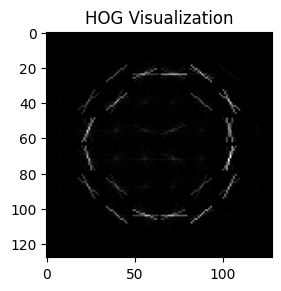

In [15]:
# visualize HOG feature
plt.subplot(1,2,2)
plt.imshow(hog_feature, cmap='gray')
plt.title('HOG Visualization')